# How to use mcFano feature selection tool

In [1]:
import scanpy as sc

from BigSur.feature_selection import mcfano_feature_selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sc.set_figure_params(dpi=100)

TypeError: metaclass conflict: the metaclass of a derived class must be a (non-strict) subclass of the metaclasses of all its bases

## Default mcFano usage:

Setup adata

In [ ]:
adata = sc.read_10x_h5('../../../Data/10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5') # read in adata
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=3)
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Run function

In [ ]:
mcfano_feature_selection(adata, layer='counts') # Replace sc.pp.highly_variable_genes(adata) call
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(adata, color='leiden')

## Checks for adata input

Reimport adata for demonstration

In [ ]:
adata = sc.read_10x_h5('../../../Data/10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5') # read in adata
adata.var_names_make_unique()
adata.layers['counts'] = adata.X.copy()

Default usage: specify adata and layer of counts

We require filtering genes before usage:

In [ ]:
mcfano_feature_selection(adata, layer='counts')

In [7]:
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
adata.shape

(11893, 22300)

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

We require passing counts, not normalized data:

In [10]:
mcfano_feature_selection(adata, layer='X')

Using 0.2 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.


Exception: This function takes raw counts, normalized data was passed.

Default scanpy pipeline:

In [11]:
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

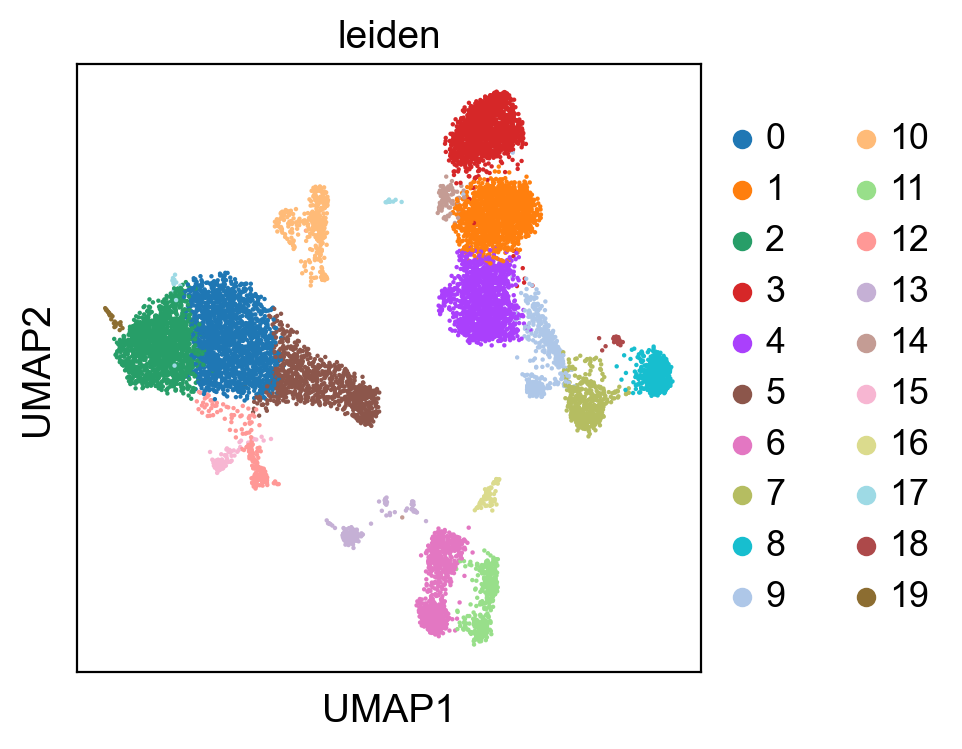

In [12]:
sc.pl.umap(adata, color='leiden')

Default mcFano usage:

In [13]:
mcfano_feature_selection(adata, layer='counts') # Replace sc.pp.highly_variable_genes(adata) call
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

Using 0.2 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.


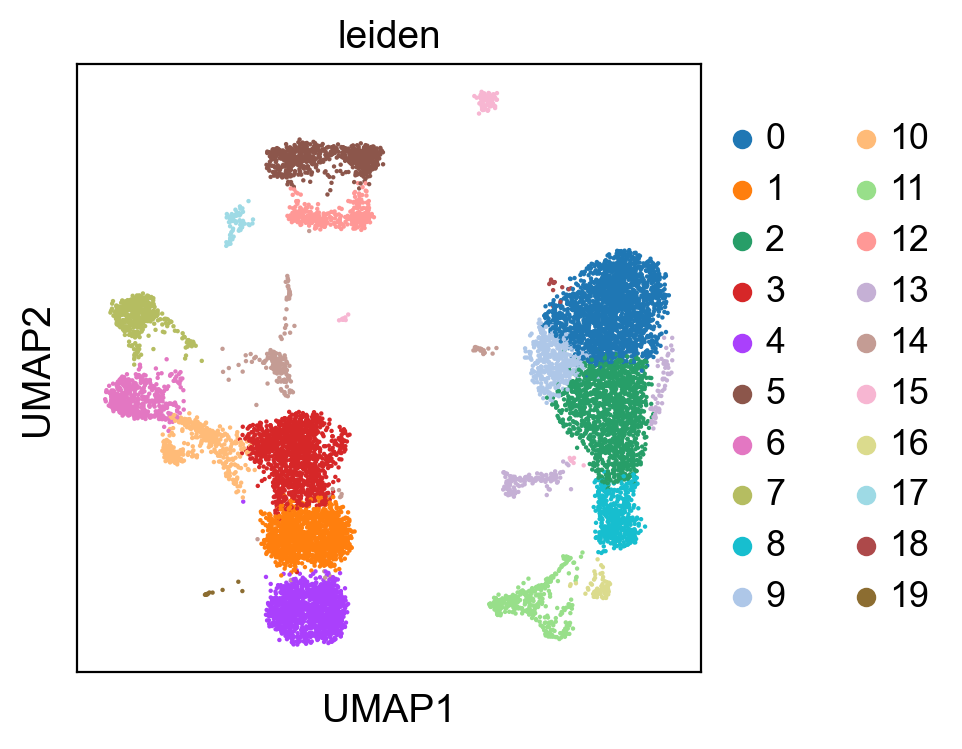

In [14]:
sc.pl.umap(adata, color='leiden')

## Advanced usage:

### Tool has 3 verbosity levels: none, a little and a lot

In [15]:
mcfano_feature_selection(adata, layer='counts', verbose=0)

In [16]:
mcfano_feature_selection(adata, layer='counts', verbose=1)

Using 0.2 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.


In [17]:
mcfano_feature_selection(adata, layer='counts', verbose=2)

Using 0.2 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.
Calculating corrected Fano factors.
Finished calculating corrected Fano factors for 22300 genes in 3.750208 seconds.
Calculating p-values.
Finished calculating p-values in 13.427533 seconds.
Setting min_fano to 1.7401.
Setting 1106 genes as highly variable.
Top 100 selected genes: 
 ['AC147651.1' 'ACRBP' 'C1QB' 'C2orf88' 'CAVIN2' 'CCL4' 'CCL5' 'CCL8'
 'CD79A' 'CDKN1C' 'CLDN5' 'CLEC1B' 'CLIC3' 'CLU' 'CMTM5' 'CST7' 'CTTN'
 'CXCL10' 'CXCL9' 'DNTT' 'FCGR3A' 'FGFBP2' 'GNG11' 'GNLY' 'GP1BB' 'GP9'
 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HBA1' 'HBA2' 'HBG2' 'HIST1H2AC' 'HOPX'
 'IFI27' 'IGHA1' 'IGHD' 'IGHG1' 'IGHG2' 'IGHG3' 'IGHG4' 'IGHM' 'IGHV3-15'
 'IGKC' 'IGKV1-39' 'IGKV1-9' 'IGKV4-1' 'IGLC1' 'IGLC2' 'IGLC3' 'IGLC6'
 'IGLC7' 'IGLV1-44' 'IGLV1-51' 'IGLV2-23' 'IGLV2-8' 'IGLV3-16' 'IGLV3-21'
 'IGLV6-57' 'IL32' 'IL7R' 'ITGA2B' 'ITM2C' 'JCHAIN' 'KLRB1' 'KLRD1'
 'KLRF1' 'LCN2' 'LILRA4' 'LYPD2' 'MS4A1' 'MS4A2' 'MYL9' '

### User can pick whether to limit the number of genes called as highly variable:

In [18]:
mcfano_feature_selection(adata, layer='counts', verbose=1, n_genes_for_PCA=400)

Using 400 top genes and 0.2 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.


In [19]:
adata.var['highly_variable'].sum()

400

Note that by default if there is a conflict between the cutoffs and the number of genes requested by the user, the cutoffs win:

In [20]:
mcfano_feature_selection(adata, layer='counts', verbose=1, n_genes_for_PCA=10000)

Using 10000 top genes and 0.2 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.


/Users/emmanueldollinger/Documents/Projects/FeatureSelectionMethod/Code/bigsur_public/BigSur/BigSur/feature_selection.py:275: UserWarning: Number of genes meeting cutoffs (1106) is lower than user requested genes (10000). Only including genes meeting cutoff in "highly_variable" slot. Please increase the min_mcfano_cutoff, decrease the p_val_cutoff, or set either or both to False.
  warnings.warn(


In [21]:
adata.var['highly_variable'].sum()

1106

The p value cutoff can be disabled:

In [22]:
mcfano_feature_selection(adata, layer='counts', verbose=1, p_val_cutoff=None)

Using 0.95 for mcfano quantile cutoff for highly variable genes.


We do NOT recommend turning off the p value criterion; however if considering different celltypes, p value cutoff isn't necessary (and can be faster computationally): 

In [23]:
mcfano_feature_selection(adata, layer='counts', verbose=2)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

Using 0.2 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.
Calculating corrected Fano factors.
Finished calculating corrected Fano factors for 22300 genes in 3.848666 seconds.
Calculating p-values.
Finished calculating p-values in 13.794607 seconds.
Setting min_fano to 1.7401.
Setting 1106 genes as highly variable.
Top 100 selected genes: 
 ['AC147651.1' 'ACRBP' 'C1QB' 'C2orf88' 'CAVIN2' 'CCL4' 'CCL5' 'CCL8'
 'CD79A' 'CDKN1C' 'CLDN5' 'CLEC1B' 'CLIC3' 'CLU' 'CMTM5' 'CST7' 'CTTN'
 'CXCL10' 'CXCL9' 'DNTT' 'FCGR3A' 'FGFBP2' 'GNG11' 'GNLY' 'GP1BB' 'GP9'
 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HBA1' 'HBA2' 'HBG2' 'HIST1H2AC' 'HOPX'
 'IFI27' 'IGHA1' 'IGHD' 'IGHG1' 'IGHG2' 'IGHG3' 'IGHG4' 'IGHM' 'IGHV3-15'
 'IGKC' 'IGKV1-39' 'IGKV1-9' 'IGKV4-1' 'IGLC1' 'IGLC2' 'IGLC3' 'IGLC6'
 'IGLC7' 'IGLV1-44' 'IGLV1-51' 'IGLV2-23' 'IGLV2-8' 'IGLV3-16' 'IGLV3-21'
 'IGLV6-57' 'IL32' 'IL7R' 'ITGA2B' 'ITM2C' 'JCHAIN' 'KLRB1' 'KLRD1'
 'KLRF1' 'LCN2' 'LILRA4' 'LYPD2' 'MS4A1' 'MS4A2' 'MYL9' '

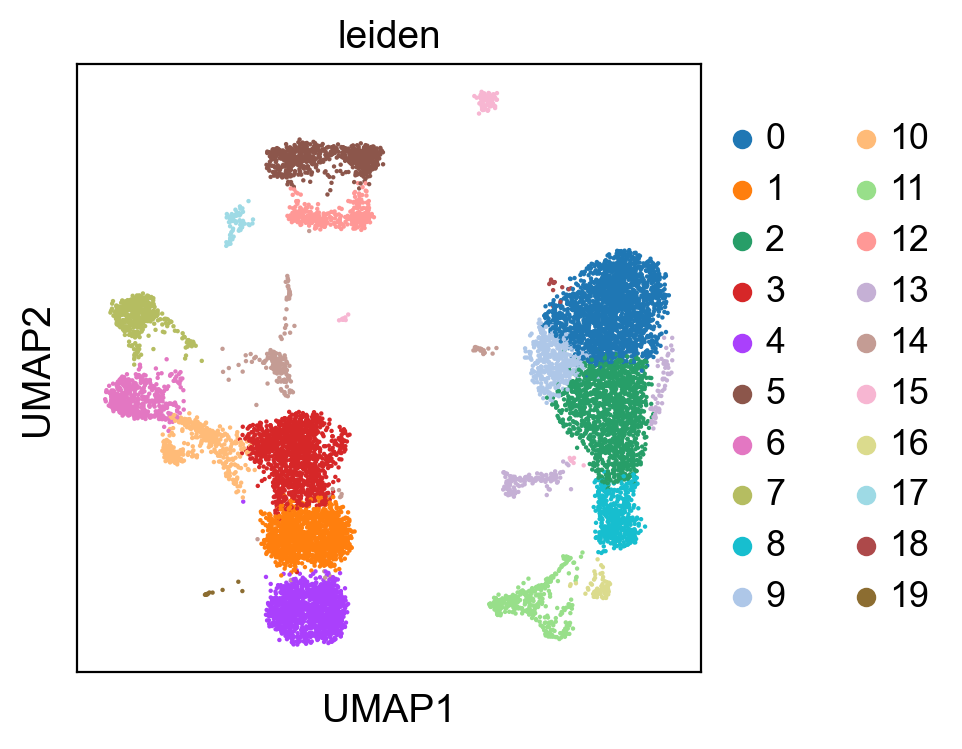

In [24]:
sc.pl.umap(adata, color='leiden')

In [25]:
mcfano_feature_selection(adata, layer='counts', p_val_cutoff=None, verbose=2)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
#sc.tl.leiden(adata) not recalculate leiden to show difference

Using 0.95 for mcfano quantile cutoff for highly variable genes.
Calculating corrected Fano factors.
Finished calculating corrected Fano factors for 22300 genes in 3.975739 seconds.
Skipping p-value calculation.
Setting min_fano to 1.7401.
Setting 1115 genes as highly variable.
Top 100 selected genes: 
 ['AC147651.1' 'ACRBP' 'C1QB' 'C2orf88' 'CAVIN2' 'CCL4' 'CCL5' 'CCL8'
 'CD79A' 'CDKN1C' 'CLDN5' 'CLEC1B' 'CLIC3' 'CLU' 'CMTM5' 'CST7' 'CTTN'
 'CXCL10' 'CXCL9' 'DNTT' 'FCGR3A' 'FGFBP2' 'GNG11' 'GNLY' 'GP1BB' 'GP9'
 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HBA1' 'HBA2' 'HBG2' 'HIST1H2AC' 'HOPX'
 'IFI27' 'IGHA1' 'IGHD' 'IGHG1' 'IGHG2' 'IGHG3' 'IGHG4' 'IGHM' 'IGHV3-15'
 'IGKC' 'IGKV1-39' 'IGKV1-9' 'IGKV4-1' 'IGLC1' 'IGLC2' 'IGLC3' 'IGLC6'
 'IGLC7' 'IGLV1-44' 'IGLV1-51' 'IGLV2-23' 'IGLV2-8' 'IGLV3-16' 'IGLV3-21'
 'IGLV6-57' 'IL32' 'IL7R' 'ITGA2B' 'ITM2C' 'JCHAIN' 'KLRB1' 'KLRD1'
 'KLRF1' 'LCN2' 'LILRA4' 'LYPD2' 'MS4A1' 'MS4A2' 'MYL9' 'MZB1' 'NKG7'
 'NRGN' 'PDGFA' 'PDZK1IP1' 'PF4' 'PF4V1' 'PPBP' 'PRF1' 'P

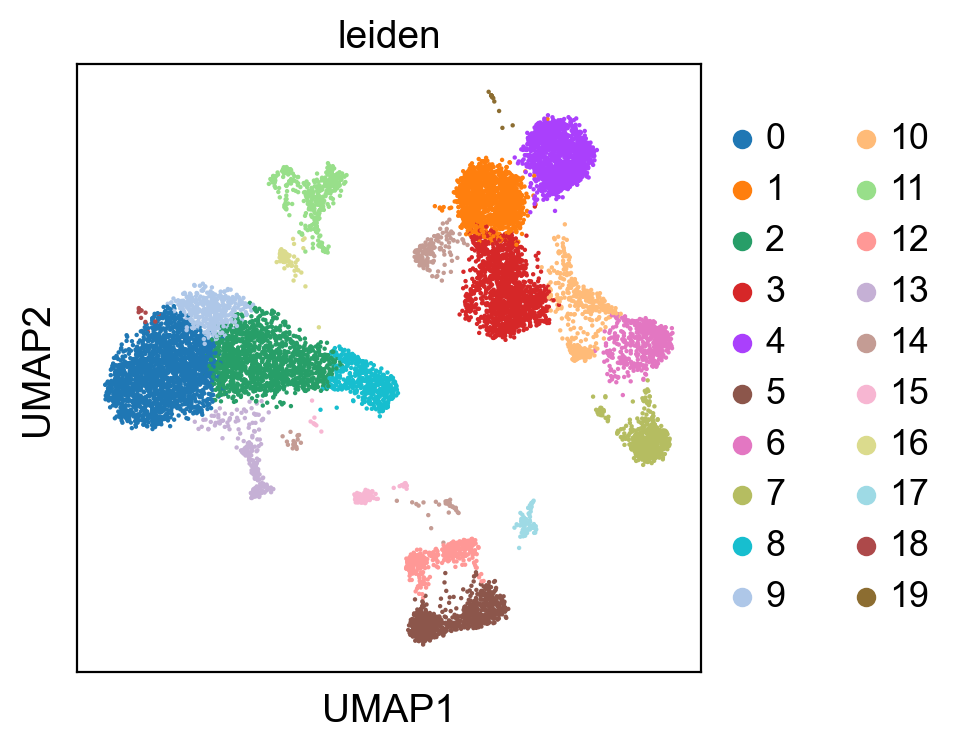

In [26]:
sc.pl.umap(adata, color='leiden')

UMAPs are similar

### Fitting coefficient of variation

CV is the only parameter in our model. We've found that using a CV of 0.5 is usually sufficient, but we also provide a way to fit CV:

Note that fitting CV is only necessary if the dataset being considered is cells that are similar (i.e. intra celltype analysis). Fitting CV for inter celltype analysis will take very long and probably won't work (function is designed to throw an error). 

In [27]:
PBMC=sc.read('../../../Data/10kPBMC_working.h5ad')

PBMC.uns['log1p']['base'] = None

In [28]:
CD4 = PBMC[PBMC.obs['GroupedIdents'].isin(['CD4+ T Cells'])].copy()

sc.pp.filter_genes(CD4, min_cells=3)
mcfano_feature_selection(CD4, layer='counts', cv=None) # Fit CV

Using 0.2 for pvalue cutoff and 0.95 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.25


In [29]:
?mcfano_feature_selection

Signature:
mcfano_feature_selection(
    adata: anndata._core.anndata.AnnData,
    layer: str,
    cv: Union[bool, float] = 0.5,
    n_genes_for_PCA: Union[bool, int] = False,
    min_mcfano_cutoff: Union[bool, float] = 0.95,
    p_val_cutoff: Union[bool, float] = 0.2,
    return_residuals: bool = False,
    n_jobs: int = -2,
    verbose: int = 1,
)
Docstring:
Calculate the corrected Fano factor for all genes in the dataset. mc_Fano column will be added to .var. Highly_variable column will be added to .var based on the n_genes_for_pca, min_mcfano_cutoff and p_val_cutoff parameters.

Parameters
----------
adata - adata object containing information about the raw counts and gene names.
layer - String, describing the layer of adata object containing raw counts (pass "X" if raw counts are in adata.X).
cv - Float, coefficient of variation for the given dataset. If None, the CV will be estimated.
n_genes_for_PCA - [Int, Bool], top number of genes to use for PCA, ranked by corrected modified 

Package list:

In [30]:
!cat environment.yml

name: FanoFeatureSelection
channels:
  - anaconda
  - bioconda
  - conda-forge
  - defaults
dependencies:
  - _r-mutex=1.0.1=anacondar_1
  - adjusttext=0.7.3.1=py_1
  - alabaster=0.7.13=pyhd8ed1ab_0
  - anndata=0.8.0=pyhd8ed1ab_1
  - anndata2ri=1.1=pyhdfd78af_0
  - anyio=3.6.2=pyhd8ed1ab_0
  - aom=3.5.0=hf0c8a7f_0
  - applaunchservices=0.3.0=pyhd8ed1ab_2
  - appnope=0.1.3=pyhd8ed1ab_0
  - argon2-cffi=21.3.0=pyhd8ed1ab_0
  - argon2-cffi-bindings=21.2.0=py310h90acd4f_3
  - arpack=3.7.0=hefb7bc6_2
  - arrow=1.2.3=pyhd8ed1ab_0
  - astroid=2.13.3=py310h2ec42d9_0
  - atomicwrites=1.4.1=pyhd8ed1ab_0
  - attrs=22.2.0=pyh71513ae_0
  - autopep8=1.6.0=pyhd8ed1ab_1
  - babel=2.11.0=pyhd8ed1ab_0
  - backcall=0.2.0=pyh9f0ad1d_0
  - backports=1.0=pyhd8ed1ab_3
  - backports.functools_lru_cache=1.6.4=pyhd8ed1ab_0
  - beautifulsoup4=4.11.1=pyha770c72_0
  - binaryornot=0.4.4=py_1
  - bioconductor-biobase=2.54.0=r41h3be46a4_2
  - bioconductor-biocgenerics=0.40.0=r41hdfd78af_0
  - bioconductor-delayedarray